In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)

if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
/device:GPU:0
Found GPU at: /device:GPU:0


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.0


In [ ]:
pip install tensorflow==2.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 106.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 100.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting un

In [ ]:
#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import Sequential
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,Dropout,Input, ZeroPadding2D
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential, Model
import keras.backend as K
from sklearn.metrics import log_loss
# Utils
import os
import cv2
from sklearn.utils import shuffle
from pathlib import Path
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time

#mount drive
from google.colab import drive
drive.mount("/content/drive")

#Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score


# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
from glob import glob
import random



Mounted at /content/drive


In [ ]:
def img_Generator(file_name,gen_type,size):
    if gen_type=='yes':
        generet_Data=ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
        gen_data=generet_Data.flow_from_directory(file_name,target_size=(size, size),
                                                  batch_size=32,shuffle=True,
                                                  class_mode='categorical')

    else:
        generet_Data1=ImageDataGenerator()
        gen_data=generet_Data1.flow_from_directory(file_name,target_size=(size, size),
                                                  batch_size=32,shuffle=False,
                                                  class_mode='categorical')

    return gen_data

In [ ]:
#EfficientNetB4
efficientnet_size=380
image_path=Path('/content/drive/MyDrive/TA/Data/split')
data_typ='yes'
train_data=img_Generator(str(image_path)+'/train/',data_typ,efficientnet_size)
data_typ='no'
test_data=img_Generator(str(image_path)+'/test/',data_typ,efficientnet_size)
pdata_typ='no'
val_data=img_Generator(str(image_path)+'/val/',data_typ,efficientnet_size)


Found 2438 images belonging to 10 classes.
Found 821 images belonging to 10 classes.
Found 810 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
efficientnet_base_model = EfficientNetB4(include_top=False, weights='imagenet',input_tensor=None, input_shape=(efficientnet_size,efficientnet_size,3), classes=10)

In [ ]:
print("weights:", len(efficientnet_base_model.weights))
print("trainable_weights:", len(efficientnet_base_model.trainable_weights))
print("non_trainable_weights:", len(efficientnet_base_model.non_trainable_weights))

weights: 611
trainable_weights: 416
non_trainable_weights: 195


In [ ]:
int(20/100*611)

122

In [ ]:
#remove few dense layer from model
for layer in efficientnet_base_model.layers:
  layer.trainable = False
# for layer in efficientnet_base_model.layers[-183:]:
#     if not isinstance(layer, layers.BatchNormalization) and isinstance(layer, layers.GlobalAveragePooling2D):
#       layer.trainable = True
for layer in efficientnet_base_model.layers[-122:]:
  layer.trainable = True

In [ ]:
print("weights:", len(efficientnet_base_model.weights))
print("trainable_weights:", len(efficientnet_base_model.trainable_weights))
print("non_trainable_weights:", len(efficientnet_base_model.non_trainable_weights))

weights: 611
trainable_weights: 107
non_trainable_weights: 504


In [ ]:
efficentmodel = Sequential()
efficentmodel.add(efficientnet_base_model)
efficentmodel.add(layers.Flatten())
# efficentmodel.add(layers.Dense(1024 ,activation='relu'))
# efficentmodel.add(BatchNormalization())
efficentmodel.add(layers.Dense(10, activation ='softmax'))
efficentmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 12, 12, 1792)     17673823  
                                                                 
 flatten_1 (Flatten)         (None, 258048)            0         
                                                                 
 dense_1 (Dense)             (None, 10)                2580490   
                                                                 
Total params: 20,254,313
Trainable params: 14,812,886
Non-trainable params: 5,441,427
_________________________________________________________________


In [ ]:
efficentmodel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
batch_size = 32
# Training model
n_training_samples = len(train_data)
t0 = time.time()
efficient_history = efficentmodel.fit(
    train_data,
    epochs=200,
     validation_data=val_data,
    # steps_per_epoch =(n_training_samples//batch_size)*2,
    shuffle = True,
    callbacks=callbacks_list
    )
record_time =time.time()-t0
print("Training time:", record_time)

Epoch 1/200
77/77 [==============================] - 1113s 14s/step - loss: 4.5820 - accuracy: 0.5714 - val_loss: 5.3245 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 2/200
77/77 [==============================] - 120s 2s/step - loss: 3.2236 - accuracy: 0.7506 - val_loss: 7.4521 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 3/200
77/77 [==============================] - ETA: 0s - loss: 3.0316 - accuracy: 0.7986
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
77/77 [==============================] - 133s 2s/step - loss: 3.0316 - accuracy: 0.7986 - val_loss: 8.0166 - val_accuracy: 0.7383 - lr: 0.0010
Epoch 4/200
77/77 [==============================] - 120s 2s/step - loss: 1.6660 - accuracy: 0.8815 - val_loss: 2.5633 - val_accuracy: 0.8815 - lr: 3.0000e-04
Epoch 5/200
77/77 [==============================] - 120s 2s/step - loss: 0.8350 - accuracy: 0.9143 - val_loss: 1.8301 - val_accuracy: 0.9099 - lr: 3.0000e-04
Epoch 6/200
77/77 [==============================] - 120

In [20]:
#save the model
efficentmodel.save('/content/drive/MyDrive/TA/Models/EfficientNet/EfficientNet_Adam_20_val')

26/26 [==============================] - 247s 10s/step


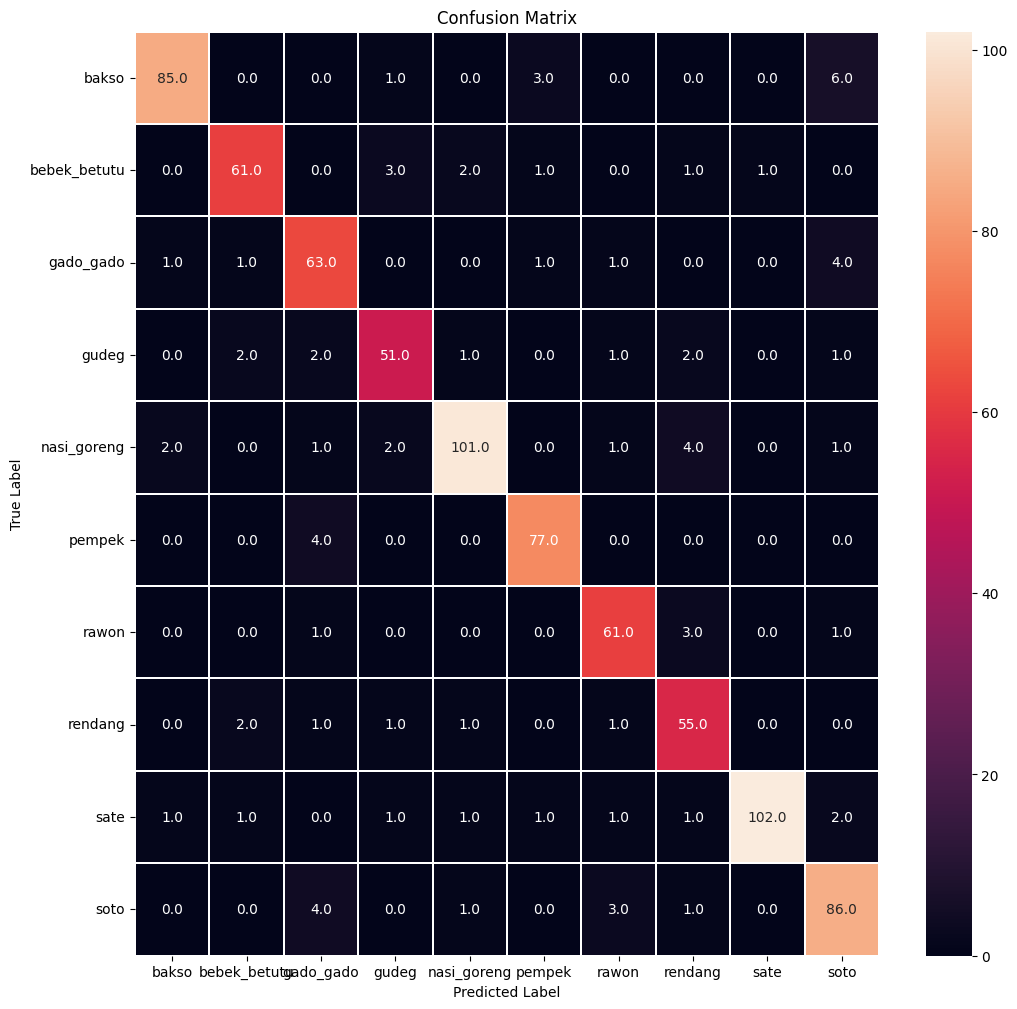

In [21]:
y_val = test_data.classes
y_pred = efficentmodel.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_val)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_data.class_indices, rotation=0)
ax.yaxis.set_ticklabels(test_data.class_indices, rotation=0)
plt.title("Confusion Matrix")
plt.show()

In [22]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_pred, y_val)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_pred, y_val, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_pred, y_val, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, y_val, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.903776
Precision: 0.897722
Recall: 0.901859
F1 score: 0.899056


In [23]:
efficentmodel = tf.keras.models.load_model('/content/drive/MyDrive/TA/Models/EfficientNet/EfficientNet_Adam_20')

26/26 [==============================] - 13s 415ms/step


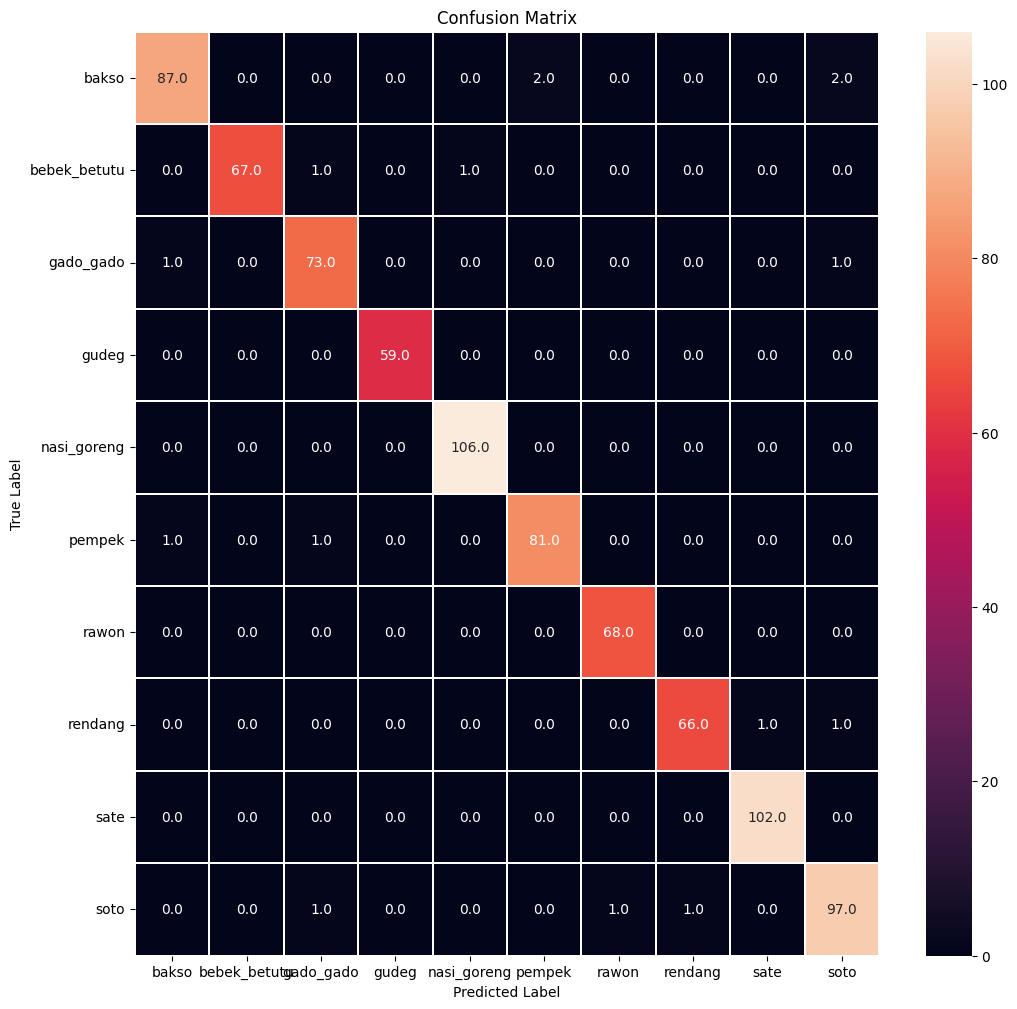

In [24]:
y_val = test_data.classes
y_pred = efficentmodel.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_val)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_data.class_indices, rotation=0)
ax.yaxis.set_ticklabels(test_data.class_indices, rotation=0)
plt.title("Confusion Matrix")
plt.show()

In [25]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_pred, y_val)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_pred, y_val, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_pred, y_val, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, y_val, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.981730
Precision: 0.982588
Recall: 0.981688
F1 score: 0.982083


In [ ]:
test_data.